In [1]:
import pandas as pd
import xlrd
from xlrd import open_workbook
from scipy.stats import pearsonr 
from scipy.stats import powerlaw
from collections import Counter
from scipy.stats import pearsonr
from scipy.stats import linregress 
import powerlaw
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import warnings
import numpy as np
import scipy as sp
import pprint
import operator
import math
from math import sin, cos, sqrt, atan2, radians
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
excel_file ='DataClean.xlsx'
linknetwork= pd.read_excel(excel_file, sheet_name='Links',index_col=0)
nodenetwork= pd.read_excel(excel_file, sheet_name='NodeCode', index_col=0)
coordinates= pd.read_excel(excel_file, sheet_name='Coordinates', index_col=0)
demandnetwork= pd.read_excel(excel_file, sheet_name='Demand', index_col=0)
lines=pd.read_excel(excel_file, sheet_name='Lines', index_col=0)
link_count = linknetwork.shape[0]
node_count = nodenetwork.shape[0]
line_count=lines.shape[0]
demand_count=demandnetwork.shape[0]
coordinates = coordinates.shape[0]
book = open_workbook('Dataclean.xlsx')
link_data = book.sheet_by_name('Links') #read link file and correct sheet
node_data = book.sheet_by_name('NodeCode') #read node file and correct sheet
coor_data = book.sheet_by_name('Coordinates') #read coordinate file
line_data = book.sheet_by_name('Lines')
demand_data = book.sheet_by_name('Demand')
NodeLabel={} #create dictionary to name nodes based on station label
NodeLines={} #create dictionary to determine which lines serve which node
for i in range(link_count):
    if link_data.cell_value(i+1, 2) not in NodeLabel:
        for j in range(node_count):
            if int(node_data.cell_value(j+1, 0)) == int(link_data.cell_value(i+1, 2)):
                NodeLabel[int(link_data.cell_value(i+1, 2))]= node_data.cell_value(j+1, 1)    
    if link_data.cell_value(i+1, 3) not in NodeLabel:
        for j in range(node_count):
            if int(node_data.cell_value(j+1, 0)) == int(link_data.cell_value(i+1, 3)):
                NodeLabel[int(link_data.cell_value(i+1, 3))]= node_data.cell_value(j+1, 1)
for i in NodeLabel:
    NodeLines[i]=[]
    for j in range(link_count):
        if link_data.cell_value(j+1,2) == i:
            if link_data.cell_value(j+1,5) not in NodeLines[i]:
                NodeLines[i].append(int(link_data.cell_value(j+1,5)))
        if link_data.cell_value(j+1,3) == i:
            if link_data.cell_value(j+1,5) not in NodeLines[i]:
                NodeLines[i].append(int(link_data.cell_value(j+1,5)))

#Compute the number of internal nodes and links where external nodes van a label value of > 9900
Internal_nodes=0
for i in NodeLabel:
    if i < 9900:
        Internal_nodes += 1
IntLinks=0
for i in range(link_count):
    if link_data.cell_value(i+1, 2) < 9900 or link_data.cell_value(i+1, 3) < 9900:
        IntLinks += 1
        
#Import demand data and create OD matrix
DemandData={}
for i in range(1, demand_count+1):
    for j in range(1, demand_count+1):
        #if (int(demand_data.cell_value(i,0) >= 9900 and int(demand_data.cell_value(0,j)) >= 9900)):
            #DemandData[int(demand_data.cell_value(i,0)),int(demand_data.cell_value(0,j))] = 0  
        #else:
        DemandData[int(demand_data.cell_value(i,0)),int(demand_data.cell_value(0,j))]= demand_data.cell_value(i,j)

#read the characteristics of each Line        
LineData={} 
for i in range(line_count):
    LineData[int(line_data.cell_value(i+1,0))]={}
    LineData[line_data.cell_value(i+1,0)]["Modality"]= line_data.cell_value(i+1,1)
    LineData[line_data.cell_value(i+1,0)]["Speed"]= line_data.cell_value(i+1,2)
    LineData[line_data.cell_value(i+1,0)]["Frequency"]= line_data.cell_value(i+1,3)
        

In [3]:
#Determine the location of each node and validate each node is given a location
NodeLat={}
NodeLeng={}
NodeValidation={}
for i in NodeLabel:
    for j in range(1,coordinates+1):
        if i == coor_data.cell_value(j,1):
            NodeLat[i]= coor_data.cell_value(j,5)
            NodeLeng[i]= coor_data.cell_value(j,6)
            NodeValidation[i]= "Yes"
    #some stops are not in the coordinate data set due to temporal rerouting, these are checked manually
    if i not in (NodeValidation):
        NodeLat[i]=0 
        NodeLeng[i]=0
        NodeValidation[i]= "No"    

In [4]:
#Determine the distance between nodes which can be used to check if nodes are to closed and also to determine the link distance
R = 6373.0 # approximate radius of earth in km
InList=[]
Dist={}
for i in NodeLabel:
    Dist[i]={}
    for j in NodeLabel:
        if i != j:
            Dist[i][j]=0
            if NodeLat[i] != 0:
                lat1 = radians(float(NodeLat[i]))
                lon1 = radians(float(NodeLeng[i]))
                lat2 = radians(float(NodeLat[j]))
                lon2 = radians(float(NodeLeng[j]))

                dlon = lon2 - lon1
                dlat = lat2 - lat1

                a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))
                Dist[i][j]= R * c * 1000
                distance = R * c * 1000 #calculate distance in meters between every node
#                 if distance < 150: # if the distance is smaller than 150 metres for two nodes, print the nodes
#                     if NodeLabel[i] != NodeLabel[j]:
#                         if ([NodeLabel[i], NodeLabel[j]]) not in InList:
#                             print (NodeLabel[i], '&' , NodeLabel[j])
#                             InList.append([NodeLabel[i], NodeLabel[j]])
#                             InList.append([NodeLabel[j], NodeLabel[i]])

In [5]:
# for i in range(link_count):
#         if Dist[link_data.cell_value(i+1,2)][link_data.cell_value(i+1,3)] > 3000:
#             if link_data.cell_value(i+1,2) < 9900 and link_data.cell_value(i+1,3) < 9900:
#                 print(round(Dist[link_data.cell_value(i+1,2)][link_data.cell_value(i+1,3)],1), 
#                   NodeLabel[link_data.cell_value(i+1,2)], NodeLabel[link_data.cell_value(i+1,3)], link_data.cell_value(i+1,5))

In [6]:
# # If there are duplicates in the NodeLabels, this code can filter them
# Duplicates=[]
# DuplicatesNo={}
# for k in (NodeLabel):
#     for l in (NodeLabel):
#         if k != l:
#             if NodeLabel[k] == NodeLabel[l]:
#                 if NodeLabel[k] not in Duplicates:
#                     Duplicates.append(NodeLabel[k])
# for i in Duplicates:
#     DuplicatesNo[i]=[]
#     for j in NodeLabel:
#         if NodeLabel[j] == i:
#             DuplicatesNo[i].append(j)
# # for i in DuplicatesNo:
# #     for j in DuplicatesNo[i]:
# #         for k in DuplicatesNo[i]:
# #              if j != k:
# #                 if Dist[j][k] > 200:
# #                     print(i, j, NodeLines[j])
# #                     print(i, k, NodeLines[k])
# DuplicatesNo

In [7]:
LineIndex=[] #give PT line index number 
LineStops=[] #number of stops per line
for i in range(link_count): #loop over all nodes
    if link_data.cell_value(i+1, 5) not in LineIndex: #if a line number is not added yet
        LineIndex.append(int(link_data.cell_value(i+1, 5))) #add line index
        LineStops.append(1) #set number of stops to 1 initially
for i in range(len(LineIndex)): #loop over all links
    index=LineIndex[i] #set index to recall the line
    x=[] #create variable x to define the highest stopnumber for a line
    for j in range(link_count+1):
        if link_data.cell_value(j, 5) == index: #if a node is served by a line
            x = link_data.cell_value(j, 1) #set x to value of stopnumber
            if x > int(LineStops[i]): #if x is higher than current highest stop number
                LineStops[i]=int(x) #LineStops becomes x                                
NumberOfLinks={}
for i in range(len(LineIndex)):
    j=LineIndex[i]
    k=LineStops[i]
    NumberOfLinks[j] =  k
LineOverview={} 
StopsPerLine={}
for j in LineIndex:
    StopsPerLine[j]=[]
    LineOverview[j]=[]
    for i in range(link_count+1):
        if link_data.cell_value(i, 5) == j:
            for k in range(1,(NumberOfLinks[j]+1)):
                if link_data.cell_value(i,1) == k: 
                    if NodeLabel[int(link_data.cell_value(i, 2))] not in StopsPerLine[j]:
                        StopsPerLine[j].append(NodeLabel[int(link_data.cell_value(i, 2))])
                        LineOverview[j].append(int(link_data.cell_value(i, 2)))
                    if NodeLabel[int(link_data.cell_value(i, 3))] not in StopsPerLine[j]:
                        StopsPerLine[j].append(NodeLabel[int(link_data.cell_value(i, 3))])
                        LineOverview[j].append(int(link_data.cell_value(i, 3)))
G=nx.empty_graph(NodeLabel,create_using=nx.Graph())
#G=nx.empty_graph(NodeNo,create_using=nx.Graph()) #create graph
for i in LineIndex: #Loop over number of Lines
    for j in range(len(LineOverview[i])):
        if j != len(LineOverview[i])-1:
            k=j+1
            x=LineOverview[i][j]
            y=LineOverview[i][k]
            G.add_edge(x,y) #Add a link between nodes k & l as it serves link j-1 - j for line index                        
#nx.draw_networkx(G, with_labels=True) #draw the graph
#nx.write_gexf(G, "Amsterdam.gexf") #export the graph to gephi file
A = nx.adjacency_matrix(G)
A.shape[0]


587

In [8]:
edge_lines={}
P_Graph = nx.Graph() #Create the P_Graph for element A and B
GE=nx.Graph()
G=nx.Graph() #Create graph in the L-space for element C and network visualization 
for i in NodeLabel:
    G.add_node(i)
    if i < 9900: #only add internal nodes
        GE.add_node(i,  leng=float(NodeLeng[i]), lat=float(NodeLat[i]))
        P_Graph.add_node(i)
for i in LineIndex: #Loop over number of Lines
    for j,k in zip(range(len(LineOverview[i])-1), range(1,len(LineOverview[i]))):
            x=LineOverview[i][j]
            y=LineOverview[i][k]
            link_weight = Dist[x][y] / LineData[i]["Speed"]*3.6
            for add in range(1,link_count+1):
                if int(link_data.cell_value(add, 5)) == i:
                       if int(link_data.cell_value(add, 2)) == x:
                              if int(link_data.cell_value(add, 3)) == y:
                                    if link_data.cell_value(add, 7) != '':
                                        link_weight += link_data.cell_value(add, 7)*60 #add stop time
                                        if link_data.cell_value(add, 8) != '':
                                                link_weight += link_data.cell_value(add, 8)*300 #add transfer time                
            G.add_edge(x,y, weight = link_weight) #Add a link between nodes k & l as it serves link j-1 - j for line index
    for j in LineOverview[i]:
        for k in LineOverview[i]:
            if j != k:
                if (j < 9900 and k < 9900): #Only add internal links as external nodes are excluded
                    P_Graph.add_edge(j,k)

for i in range(1,link_count+1): 
    if int(link_data.cell_value(i, 2)) < 9900 and int(link_data.cell_value(i, 3)) < 9900:
        GE.add_edge(int(link_data.cell_value(i, 2)), int(link_data.cell_value(i, 3)))
                    
#Determine clustering coefficient for Element B
Clustering = nx.clustering(P_Graph)

#Determine eigenvector centrality for Element A
EV = nx.eigenvector_centrality(P_Graph, max_iter=100)
Max_EV = sorted(EV.items(), key=operator.itemgetter(1), reverse=True)
EV_Weight = {}
for i in EV:
    EV_Weight[i] = EV[i] / (Max_EV[0][1])

In [9]:
#Create GG graph for shortest paths where each node is a combination of a node and line
GG=nx.DiGraph()
GG_Label={}
GG_Node={}
for i in NodeLabel:
    GG_Node= 'origin',i
    GG.add_node(GG_Node)
    GG_Node= 'destination',i
    GG.add_node(GG_Node)
for i in LineIndex:
    GG_Label[i]=[]
    for j in LineOverview[i]:
        GG_Label[i].append(j)
    for j in GG_Label[i]:
        GG_Node = i,j
        GG.add_node(GG_Node)

GG_weight=0        
for i in GG.nodes:
    k=i[1]
    for j in GG.nodes:
        if k==j[1]:
            if i[0] != j[0]:
                if (i[0] != 'origin' and i[0] != 'destination'):
                    for freq in range(1,line_count+1):
                        if line_data.cell_value(freq,0) == j[0]:
                            GG.add_edge(i,j, weight = 180 + 3600/int(line_data.cell_value(freq,3))/2)
                elif i[0] == 'origin' and j[0] != 'destination':
                     GG.add_edge(i,j, weight = 0) #give high value of wait to prevent going through origin and destination nodes
                elif i[0] == 'destination' and j[0] != 'origin':
                     GG.add_edge(j,i, weight = 0) #give high value of wait to prevent going through origin and destination nodes
    if (i[0] != 'origin' and i[0] != 'destination'):
        for l in G.edges(i[1]):
            for m in GG.nodes:
                if i[0] == m[0]:
                    if m[1] == l[1]:
                        GG_weight = G.get_edge_data(i[1], m[1])['weight'] + 60 #plus stopping time
                        GG.add_edge(m,i, weight = GG_weight)
        

In [10]:
#Determine where the common corridors are located to prevent possible transfers in corridors by removing transfer edges
CommonCorridor={}
CommonEdges={}
for i in G.edges:
    CommonEdges[i]=[]
    for j in GG.edges:
        if j[0][1] == i[0] and j[1][1] == i[1]:
            if j[0][0] not in CommonEdges[i]:
                CommonEdges[i].append(j[0][0])            
        elif j[0][1] == i[1] and j[1][1] == i[0]:
            if j[0][0] not in CommonEdges[i]:
                CommonEdges[i].append(j[0][0])
for i in CommonEdges:
    if len(CommonEdges[i]) > 1:
        CommonCorridor[i]=CommonEdges[i]
CorridorNodes=[]
for i in CommonCorridor:
    for j in CommonCorridor:
        if i != j:
            if i[0] == j[0] or i[0] == j[1]:
                if G.degree(i[0]) <= 2:
                    if CommonCorridor[i] == CommonCorridor[j]:
                        if i[0] not in CorridorNodes:
                            CorridorNodes.append(i[0])    
            elif i[1] == j[0] or i[1] == j[1]:
                        if G.degree(i[1]) <= 2:
                            if CommonCorridor[i] == CommonCorridor[j]:
                                if i[1] not in CorridorNodes:
                                    CorridorNodes.append(i[1])
CorridorEdges=[]
for i in GG.edges:
    if i[0][0] != 'origin' and i[1][0] != 'destination':
        if i[0][1] == i[1][1]:
            if i[0][1] in CorridorNodes:
                CorridorEdges.append(i)
for i in CorridorEdges:
    GG.remove_edge(i[0],i[1])

In [11]:
#this code determines the shortest paths for each node pair with demand based on the weight of the edges
SP_list=[]
pair=[]
for i in GG.nodes:
    if i[0] == 'origin': #start with origin
        for j in GG.nodes:
            if i[1] != j[1]:
                if j[0] == 'destination': #end with destination
                    if int(DemandData[(i[1], j[1])]) != 0: #only calculcate the shortest path if there is demand for the nodepair
                        pair=i,j                    
                        SP_list.append(pair)
SP={}
for i in range(len(SP_list)):
    SP[(SP_list[i][0][1], SP_list[i][1][1])]= nx.shortest_path(GG, source= SP_list[i][0], target=SP_list[i][1],weight='weight')    
    

In [12]:
#Determine the transfer share for each node as part of Element C
Transfer={}
for i in NodeLabel:
    Transfer[i]=0
for i in SP:
    O=i[0]
    D=i[1]
    Demand= int(DemandData[(i[0], i[1])])
    Path=SP[i][1:-1]
    for j,k in zip(range(1,len(Path)-1),range(2,len(Path))):
        if Path[j][0] != Path[k][0]:
            Transfer[Path[j][1]] += Demand
Transfers={}
TransferShare={}
TOT_Transfers=0
for i in NodeLabel:
    if i < 9900:
        TOT_Transfers += Transfer[i]
for i in Transfer:
    if i < 9900: #only for internal nodes
        TransferShare[i]=Transfer[i]/TOT_Transfers
        if Transfer[i] > 0:
            Transfers[i]=math.log10(Transfer[i]) #take the log of transfers
        else:
            Transfers[i]=0
Max_Trans = max(Transfers.items() , key=operator.itemgetter(1))[1]
for i in Transfers:
    Transfers[i] /= Max_Trans
sorted_Transfers = sorted(Transfers.items(), key=operator.itemgetter(1), reverse=True)

In [13]:
node={} #Create dictionary for node information
eA={}
eB={}
eC={}
H={} #Create dict for sorting the hierarchical degree of nodes
HD={}
for i in (NodeLabel):
    if i < 9900:
        if G.degree[i] > 2: #only if degree is higher than 2 the hierarchical degree can be computed
            eA[i]=EV_Weight[i]   #variable for eA
            eB[i]=(1-Clustering[i]) #formula for eB
            eC[i]=(Transfers[i]*((G.degree[i]-2)/G.degree[i])) #formula for eC
        else: #if the degree is lower or equal than 2, no values can be computed and are set to 0
            eA[i]=0
            eB[i]=0
            eC[i]=0
        H[NodeLabel[i]]=eA[i]*eB[i]*eC[i] #calculate the hierarchical degree
        HD[i]= eA[i]*eB[i]*eC[i]
        if H[NodeLabel[i]] != 0: #for every node which has a hierarchical degree which is not 0
            node[i]= {'Node ID': i,
                      'degree' : G.degree[i],
                      'eA' : eA[i],
                      'eB' : eB[i],
                      'eC' : eC[i],
                      'Hierarchical degree' : H[NodeLabel[i]]}

#Create sorted lists to determine the highest scoring nodes for each element
sorted_H = sorted(HD.items(), key=operator.itemgetter(1), reverse=True)
sorted_eA = sorted(eA.items(), key=operator.itemgetter(1), reverse=True)
sorted_eB = sorted(eB.items(), key=operator.itemgetter(1), reverse=True)
sorted_eC = sorted(eC.items(), key=operator.itemgetter(1), reverse=True)

nx.set_node_attributes(GE, HD, 'HD')
nx.write_gexf(GE, "Amsterdam.gexf")

In [14]:
for i in range(0,100):
    j= i+1
    print(j,';', NodeLabel[sorted_H[i][0]],';',round(sorted_H[i][1],3))

1 ; Centraal Station ; 0.739
2 ; Station Sloterdijk ; 0.437
3 ; Station Zuid ; 0.398
4 ; Amstelstation ; 0.309
5 ; Station Lelylaan ; 0.299
6 ; Leidseplein ; 0.283
7 ; Muiderpoortstation ; 0.227
8 ; Vijzelgracht ; 0.183
9 ; Station Bijlmer ArenA ; 0.176
10 ; Amstelveenseweg ; 0.157
11 ; Elandsgracht ; 0.156
12 ; Weesperplein ; 0.155
13 ; Linnaeusstraat ; 0.131
14 ; Burg.de Vlugtlaan ; 0.124
15 ; De Boelelaan/VU ; 0.112
16 ; Middenweg ; 0.107
17 ; De Pijp ; 0.106
18 ; Marnixstraat ; 0.105
19 ; Station Duivendrecht ; 0.101
20 ; Marnixplein ; 0.098
21 ; Mercatorplein ; 0.098
22 ; Station Holendrecht ; 0.096
23 ; Johan Huizingalaan(S) ; 0.089
24 ; Hoofddorpplein ; 0.088
25 ; Hoofdweg ; 0.087
26 ; Knooppunt Schiphol Nrd ; 0.083
27 ; Europaplein ; 0.083
28 ; Van Baerlestraat ; 0.081
29 ; Cornelis Lelylaan ; 0.081
30 ; Haarlemmerplein ; 0.08
31 ; Surinameplein ; 0.078
32 ; Molukkenstraat ; 0.077
33 ; Alexanderplein ; 0.077
34 ; Hugo de Grootplein ; 0.076
35 ; De Clercqstraat ; 0.076
36 ; Tuss

In [15]:
node[1316]

{'Node ID': 1316,
 'degree': 7,
 'eA': 0.20927360103195705,
 'eB': 0.7233926128590971,
 'eC': 0.4895247451491216,
 'Hierarchical degree': 0.07410767136073619}

In [16]:
#Get the results for the highest scoring nodes
Results={}
for i in range(0,10): #Reverse loop to begin at the end of the list
    Results[(sorted_H[i][0])]=[NodeLabel[sorted_H[i][0]],round(sorted_H[i][1],3),round(eA[sorted_H[i][0]],3)
                                , round(eB[sorted_H[i][0]],3), round(eC[sorted_H[i][0]],3)]
    print(Results[(sorted_H[i][0])])

['Centraal Station', 0.739, 1.0, 0.853, 0.867]
['Station Sloterdijk', 0.437, 0.727, 0.802, 0.749]
['Station Zuid', 0.398, 0.705, 0.77, 0.732]
['Amstelstation', 0.309, 0.593, 0.756, 0.69]
['Station Lelylaan', 0.299, 0.612, 0.751, 0.649]
['Leidseplein', 0.283, 0.815, 0.752, 0.462]
['Muiderpoortstation', 0.227, 0.58, 0.752, 0.521]
['Vijzelgracht', 0.183, 0.606, 0.628, 0.481]
['Station Bijlmer ArenA', 0.176, 0.312, 0.805, 0.702]
['Amstelveenseweg', 0.157, 0.449, 0.646, 0.541]


In [17]:
for i in NodeLabel:
    if "1e" in NodeLabel[i]:
        print(i, NodeLabel[i])

6044 1e Con. Huygensstraat
8195 1e Coehoornstraat
8259 1e Leeghwaterstraat
8098 1e v.Swindenstraat


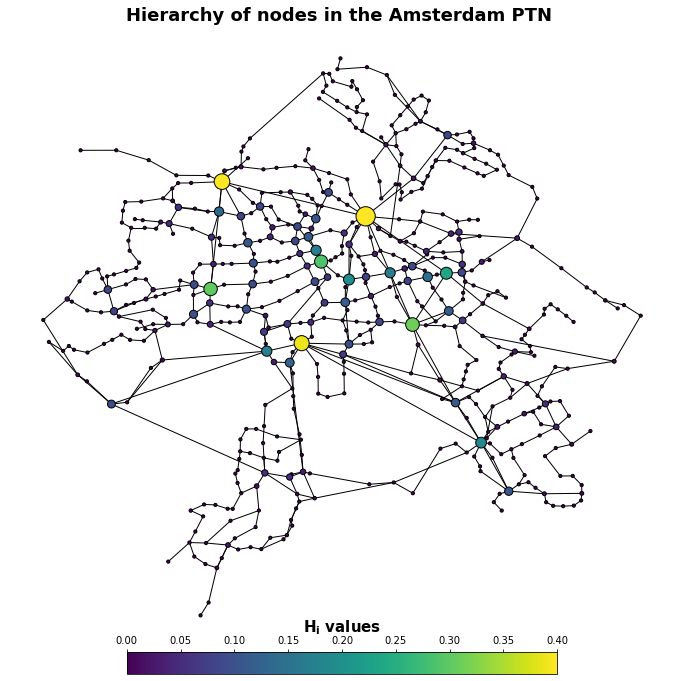

In [18]:
#Draw a map of the graph based on latitude and longtitude coordinates
sorted_ID = sorted(HD.items(), key=operator.itemgetter(1)) #order nodes from low to high
H = nx.Graph() #create graph for drawing
colormap=[] #color of nodes based on H value
size=[] #size of nodes based on H value
for i in range(len(sorted_ID)): 
    if sorted_ID[i][0] < 9900: #only internal nodes
        H.add_node(sorted_ID[i][0], pos=(float(NodeLeng[sorted_ID[i][0]]),float(NodeLat[sorted_ID[i][0]])))
        colormap.append(math.log10(1+float(sorted_ID[i][1])))
        size.append(10+1500*math.log10(1+float(sorted_ID[i][1])))    
for i in G.edges:
    if (i[0] < 9900 and i[1] < 9900): #only fully internal links
        H.add_edge(i[0],i[1])
# NodeRank={}
# rank=0
# for i in reversed(sorted_ID):
#     rank += 1
#     if rank < 10:
#         NodeRank[i[0]] = rank
#     else:
#         NodeRank[i[0]]= 
        
#Plot the figure        
plt.figure(figsize=(12,12))
# H=nx.relabel_nodes(H,NodeRank) # can be used to label the nodes
plt.title('Hierarchy of nodes in the Amsterdam PTN ', fontsize = 18, weight='bold', verticalalignment='center')
nx.draw(H, nx.get_node_attributes(H,'pos'), with_labels=False, line_edge=1, node_size=size, node_color = colormap,
        vmin = 0, vmax=0.15, cmap='viridis', linewidths=1, edgecolors='black', legend=True)
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('viridis'), norm=plt.Normalize(vmin = 0, vmax=0.4))
sm._A = []
cbar = plt.colorbar(sm, orientation="horizontal", fraction=0.033, pad=0) 
cbar.set_label(label='H$_\mathbf{i}$ values', size=15, weight='bold')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
plt.savefig('NodeHierarchy020.png')

plt.show()



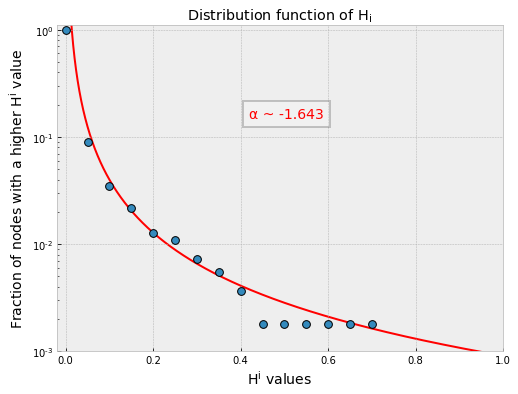

In [19]:
#Function for power-law distribution calculation
#for dist_type in [HD, eA, eB, eC]:
dist_type = HD
c = {}
values=np.arange(0,1,0.05)
data=[]
for j in values:
    Counting = 0
    for i in dist_type.values():
        if i >= j:
            Counting += 1
            if j > 0:
                data.append(j)
        c[round(j,2)]=Counting / len(HD)
x=[]
y=[]
for i in c:
    if i > 0 and c[i] > 0:
        x.append(np.log(i))
        y.append(np.log(c[i]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)
k=slope

#Create the plot
plt.figure(figsize=(8,6))
plt.style.use('bmh')
ax = plt.axes(yscale='log')
alpha_label = '\u03B1 ~ {}' .format(str(round(k,3)))
plt.ylim(0.001, 1.1)
plt.xlim(-0.02,1.0)
plt.title('Distribution function of H$\mathdefault{_i}$')
plt.xlabel('H$\mathdefault{^i}$ values', fontsize=14)
plt.ylabel('Fraction of nodes with a higher H$\mathdefault{^i}$ value', fontsize=14)
plt.scatter(*zip(*sorted(c.items())), marker='o', s=60, linewidths=1,  edgecolors='k',zorder=2)
plt.text(0.42, 0.15, alpha_label, color='r', fontsize=14,
        bbox={'facecolor': 'white', 'linestyle': 'solid',
         'linewidth': 2, 'edgecolor': 'black', 'alpha': 0.2, 'pad': 6})


rangedata = np.linspace(0.001, 1.0,100000)        
plt.plot(rangedata,np.power(rangedata,k)/(2*len(HD)),'r',zorder=1);
plt.savefig('PowerDistribution.png')
plt.show();



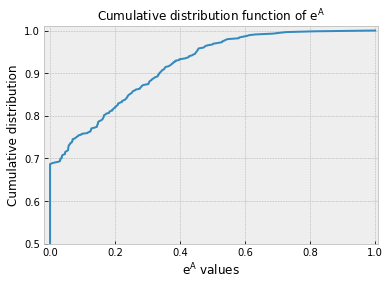

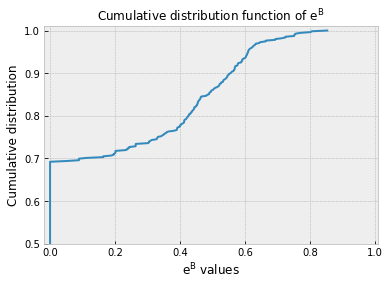

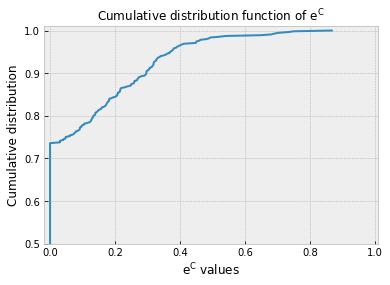

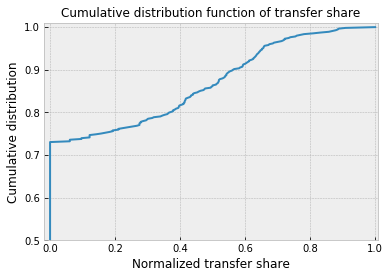

In [20]:
from scipy.stats import norm
for x,y,z in zip([eA, eB, eC, Transfers],['eA', 'eB', 'eC','Transfers'],
                 ['e$\mathdefault{^A}$', 'e$\mathdefault{^B}$', 'e$\mathdefault{^C}$', 'Normalized transfer share']):
    data=[]
    for i in x:
        data.append(x[i])
    data_sorted= list(sorted(data))
    p = 1. * np.arange(len(data)) / (len(data) - 1)

    plt.figure(figsize=(6,4))
    plt.style.use('bmh')
    plt.plot(data_sorted, p)
    plt.ylim(0.50,1.01) 
    plt.xlim(-0.02,1.01)
    plt.ylabel('Cumulative distribution')
    if z != 'Normalized transfer share':
        plt.xlabel('{} values' .format(z))
    else:
        plt.xlabel('{}' .format(z))
    if z != 'Normalized transfer share':
        plt.title('Cumulative distribution function of {}'.format(z), fontsize=12 )
    else:
        plt.title('Cumulative distribution function of transfer share', fontsize=12 )
    plt.savefig('CDF{}.png' .format(y))
    plt.show()

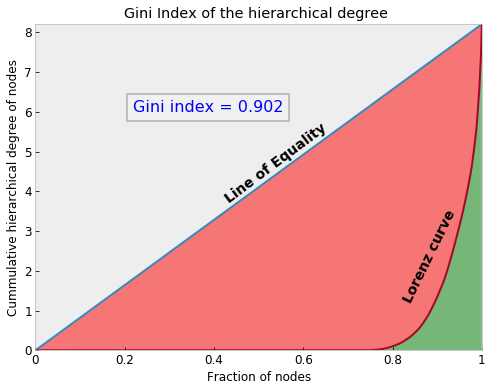

In [21]:
def gini(list_of_values): #Algorithm to define the gini index
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

Internal=[] #Add variable list for all nodes with a hierarchical degree of not zero
for i in HD:
    if i < 9900:
        Internal.append(HD[i])
Cummulative=0
Entry=list(range(1,len(Internal)+1)) #ranking for sorted hierarchical degrees based on number of entries
Ranking=sorted(Internal) #the ranking of the hierarchical degree list
Height=[0]
for i in Internal:
    Cummulative += i
for i in Ranking:
    Height.append(Height[-1]+i)
Height.pop(0) #remove first value which was added as initial
gini = round(gini(Internal),3) #the gini index value with 2 decimals

#Create the plot
plt.figure(figsize=(8,6))
plt.style.use('bmh')
x = Entry
Equal=[]
for i in Entry:
    Equal.append(i/len(Entry)*Cummulative)
y1 = Equal
y2 = Height
plt.plot([0,len(Internal)],[0,Cummulative])
plt.plot(Entry,Height)
plt.xlim(0,len(Internal))
plt.ylim(0,Cummulative)
plt.text(120, 6, 'Gini index = {}'.format(gini), color='b', fontsize=16,
        bbox={'facecolor': 'white', 'linestyle': 'solid',
         'linewidth': 2, 'edgecolor': 'black', 'alpha': 0.2, 'pad': 6})
plt.tick_params(labelsize=12)
plt.xticks(np.arange(0, len(Internal)+1,len(Internal)/5), ('0', '0.2', '0.4', '0.6', '0.8','1'))
plt.grid(False)
plt.text(450, 1.2, 'Lorenz curve', rotation=64, fontsize=14, weight='bold', zorder=2)
plt.text(230, 3.7, 'Line of Equality', rotation=37, fontsize=14, weight='bold', zorder=2)
plt.ylabel('Cummulative hierarchical degree of nodes', fontsize=12 )
plt.xlabel('Fraction of nodes', fontsize=12)
plt.fill_between(x, y1, y2, facecolor='red', interpolate=True, alpha=0.5, zorder=1)
plt.fill_between(x, 0, y2, facecolor='green', interpolate=True, alpha=0.5)
plt.title("Gini Index of the hierarchical degree ");
plt.savefig('GiniDistribution.png')


In [22]:
# #Verification of the transfer model
# Verification=[]
# VerificationSP=[]
# for i in SP:
#     VerificationSP.append(i) 
# import random
# for i in range (0,10):
#     j=random.randint(0,len(VerificationSP))
#     Verification.append(VerificationSP[j])
# for i in Verification:
#     print(SP[i])    

In [23]:
#Statistical analysis of nodes
Between= nx.betweenness_centrality(G) #use networkX tool to create dict with betweenness for each node
BetweenP = nx.betweenness_centrality(P_Graph) 
Statistics={} #Dict to capture all statistics of a node
As={} #Dict for assortativity
Modes={} #Dict for the modes serving each node for overlapping degree
OverDeg={} #Dict for degree in each layer for each node
for i in HD:
    if HD[i] != 0:
        Statistics[i]={}
        Statistics[i]['H']=HD[i]
        Statistics[i]['k']=G.degree[i]
        Statistics[i]['eA']=eA[i]
        Statistics[i]['eB']=eB[i]
        Statistics[i]['eC']=eC[i]
        As[i]=0 
        for j in G.edges(i):
            As[i] += G.degree(j[1])
        Statistics[i]['A']=As[i]/len(G.edges(i)) #Average degree of neighbors
        Statistics[i]['C']=Clustering[i]
        Modes[i]={} # add dict for each node to create a list for each mode
        OverDeg[i]=[] #add list to determine degree for each mode
        for j in NodeLines[i]:
            if LineData[j]['Modality'] not in Modes[i]: #the mode did not exist yet for the node
                Modes[i][LineData[j]['Modality']]=[j]
            else:
                Modes[i][LineData[j]['Modality']].append(j) #if the mode is already in the list
        for j in Modes[i]:
            for k in Modes[i][j]:
                for l in range(len(LineOverview[k])): #find the location of the node on the line
                    if LineOverview[k][l] == i:
                        if l != 0:
                            if [j, LineOverview[k][l-1]] not in OverDeg[i]: #add one node before node i to the list
                                OverDeg[i].append([j, LineOverview[k][l-1]])
                        if l != len(LineOverview[k])-1:
                            if [j, LineOverview[k][l+1]] not in OverDeg[i]: #add one node fater node i to the list
                                OverDeg[i].append([j, LineOverview[k][l+1]])
        Statistics[i]['O']=len(OverDeg[i])
        Statistics[i]['B']=Between[i]
        Statistics[i]['BP']=BetweenP[i]   

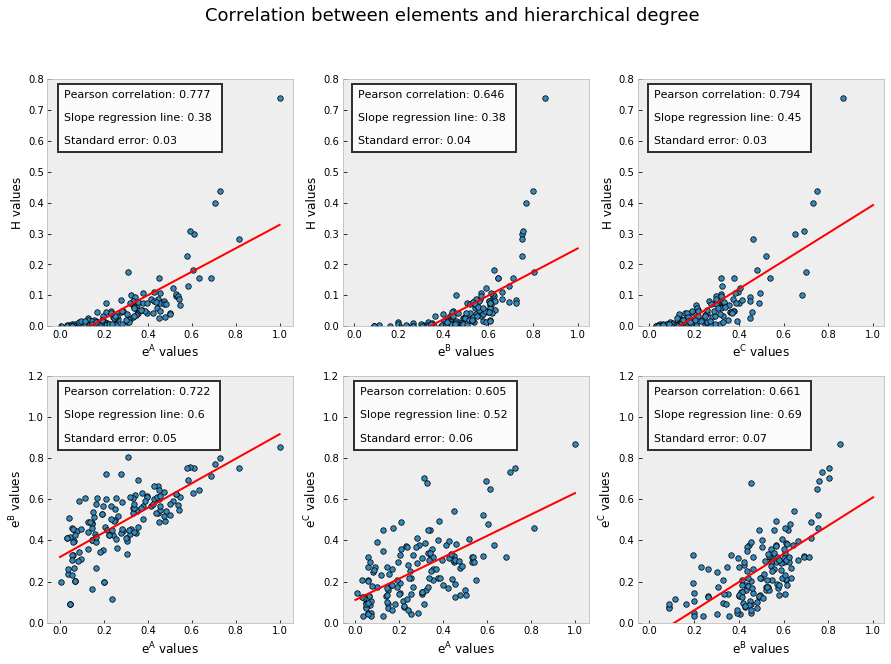

In [24]:
Stat={}   
for j in ['eA','eB','eC','H','k','A','C','O','B','BP']:
    Stat[j]=[]
    for i in Statistics:    
        Stat[j].append(Statistics[i][j])

#Plot the pearson correlation between H and the elements in one figure

fig, (axs) = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle('Correlation between elements and hierarchical degree', fontsize=18)
plt.style.use('bmh')
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs
for i,j, k, xlabels, ylabels in zip([ax1, ax2, ax3, ax4, ax5, ax6],['eA','eB','eC', 'eA','eA','eB'],['H','H','H', 'eB','eC','eC'],
                                    ['e$\mathdefault{^A}$','e$\mathdefault{^B}$','e$\mathdefault{^C}$', 
                                     'e$\mathdefault{^A}$','e$\mathdefault{^A}$','e$\mathdefault{^B}$'],
                                    ['H','H','H', 'e$\mathdefault{^B}$','e$\mathdefault{^C}$','e$\mathdefault{^C}$']):
    i.grid(b=None)
    if k == 'H':
        i.set_ylim([0, 0.8])
        height=0.59
    else:
        i.set_ylim([0, 1.2])
        height=0.88
    corr, _ = pearsonr(Stat[j], Stat[k])
    slope, intercept, r_value, p_value, std_err = linregress(Stat[j], Stat[k])
    x=np.linspace(0, 1.0,100000)
    i.plot(x, intercept + slope*x, 'r-')
    i.scatter(Stat[j], Stat[k], s=30, edgecolor='black', linewidth='0.75')
    i.set(xlabel='{} values'.format(xlabels), ylabel='{} values'.format(ylabels))
    SlopeLabel = str(round(slope,3)) 
    i.text(0.02, height, 'Pearson correlation: %s \n\nSlope regression line: %s \n\nStandard error: %s ' 
           % (round(corr,3), round(slope,2) , round(std_err,2)) , 
           color='k', fontsize=11, bbox={'facecolor': 'white', 'linestyle': 'solid', 'linewidth': 2, 
                                         'edgecolor': 'black', 'alpha': 0.8, 'pad': 6})   
plt.savefig('Correlation.png')
plt.plot;

In [25]:
#Total travel time in the network
Tot_Dem=0
Tot_TT=0
for j in SP:
    for i in range(len(SP[j])-1):
        Tot_TT += (GG.get_edge_data((SP[j][i]),(SP[j][i+1]))['weight']) * DemandData[j]
    Tot_Dem += DemandData[j]
print('Total daily travel time =', int(Tot_TT/3600), 'hours')
print('Total daily demand =', int(Tot_Dem), 'passengers')
print('Average daily travel time =', int(Tot_TT/Tot_Dem/60), 'minutes')

Total daily travel time = 342633 hours
Total daily demand = 835197 passengers
Average daily travel time = 24 minutes


In [26]:
# #Create a new excel file to couple nodes from different datasets
#import xlsxwriter

# # Create a new Excel file and add a worksheet.
# workbook = xlsxwriter.Workbook('Dataset.xlsx')
# worksheet = workbook.add_worksheet()
# worksheet.write(0,0,"NodeID")
# worksheet.write(0,1,"NodeLabel")
# j=1
# for i in NodeLabel:
#     worksheet.write(j, 0, i)
#     worksheet.write(j, 1, NodeLabel[i])
#     j += 1
# workbook.close()


In [27]:
Layer={}
for i in GE.nodes:
    if HD[i] > 0.4:
        Layer[i] = 1
    elif HD[i] > 0.1:
        Layer[i] = 2
    elif HD[i] > 0:
        Layer[i] = 3
    elif HD[i] == 0:
        Layer[i] = 4

In [28]:
#Create a new excel file to couple nodes from different datasets
import xlsxwriter

# Create a new Excel file and add a worksheet.
workbook = xlsxwriter.Workbook('DataEdges.xlsx')
worksheet = workbook.add_worksheet()
j=0
for i in GE.edges:
    worksheet.write(j, 0, i[0])
    worksheet.write(j, 1, Layer[i[0]])
    worksheet.write(j, 2, i[1])
    worksheet.write(j, 3, Layer[i[1]])
    j += 1
workbook.close()